<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/MEGprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setting up the Colab page to use neqsim
%%capture
!pip install neqsim==3.0.19
import neqsim
from neqsim.thermo.thermoTools import *

# MEG for hydrate inhibition and regeneration of MEG

**Introduction**

Monoethylene glycol (MEG) is commonly used in the oil and gas industry for hydrate inhibition in pipelines and process equipment. This process involves injecting MEG into the gas stream to prevent hydrate formation. After use, the MEG is regenerated to remove water and maintain its effectiveness. This notebook explores the principles of MEG for hydrate inhibition and regeneration, including:

* **Hydrate Formation:** Understanding the conditions that lead to hydrate formation in natural gas systems.
* **MEG Inhibition:** How MEG prevents hydrate formation by lowering the hydrate formation temperature.
* **MEG Regeneration:** Methods for removing water from MEG to restore its hydrate inhibition properties.
* **Case Studies:** Examples of MEG applications in real-world scenarios.

# Litterature

Wikipedia

https://en.wikipedia.org/wiki/Ethylene_glycol


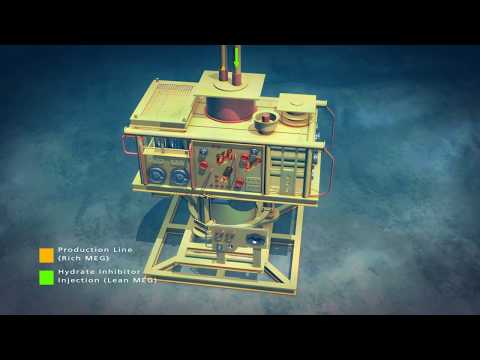

In [2]:
#@title MEG reclamation
#@markdown This video gives an intriduction to MEG reclamation
from IPython.display import YouTubeVideo
YouTubeVideo('4HosHcGvtVM', width=600, height=400)

# Development of a MEG process




In [3]:
from neqsim.thermo import fluid
from neqsim.process import clearProcess, stream, runProcess, valve
from neqsim.thermo.thermoTools import *
import pandas as pd
import neqsim
from neqsim.thermo.thermoTools import *

from neqsim.process import stream, heater, distillationColumn
# Create a gas-condensate fluid
wateretoh = {'ComponentName':  ['methane', 'water', "MEG"],
        'MolarComposition[-]':  [0.01, 0.7, 0.3]
}

gascondensatedf = pd.DataFrame(wateretoh)
print("Fluid:\n")
print(gascondensatedf.head(30).to_string())
aqueousFluid = fluid_df(gascondensatedf, lastIsPlusFraction=False).autoSelectModel()

clearProcess()

feedStream = stream('feed', aqueousFluid)
feedStream.setFlowRate(1000.0, 'kg/day')
feedStream.setPressure(1.1, 'bara')
feedStream.setTemperature(90.0, 'C')
feedStream.run()
printFrame(feedStream.getFluid())

#FRACTIONATION PROCESS
waterremoval = distillationColumn(name="deethanizer", trays=1, reboil=True, condenser=False)
waterremoval.addFeedStream(feedStream,1)
waterremoval.getReboiler().setOutTemperature(273.15+120.0)
waterremoval.setTopPressure(1.1)
waterremoval.setBottomPressure(1.1)
waterremoval.run()

printFrame(waterremoval.getGasOutStream().getFluid())

printFrame(waterremoval.getLiquidOutStream().getFluid())

Fluid:

  ComponentName  MolarComposition[-]
0       methane                 0.01
1         water                 0.70
2           MEG                 0.30
| 0                    | 1          | 2                    | 3                    | 4   | 5   | 6               |
|:---------------------|:-----------|:---------------------|:---------------------|:----|:----|:----------------|
|                      | total      | GAS                  | AQUEOUS              |     |     |                 |
| methane              | 9.90099E-3 | 5.67531E-1           | 2.87049E-5           |     |     | [mole fraction] |
| water                | 6.93069E-1 | 4.28823E-1           | 6.97748E-1           |     |     | [mole fraction] |
| MEG                  | 2.9703E-1  | 3.6461E-3            | 3.02224E-1           |     |     | [mole fraction] |
|                      |            |                      |                      |     |     |                 |
| Density              |            | 6.26258E

In [ ]:
from neqsim.thermo.thermoTools import *
from neqsim import jneqsim
import neqsim

# Create a fluid in neqsim
fluid1 = fluid("cpa")  # create a fluid using the SRK equation of state
fluid1.addComponent("CO2", 15.1)
fluid1.addComponent("water", 60.0)
fluid1.addComponent("MEG", 30.0)

fluid1.setMixingRule(10)


clearProcess()

stream1 = stream('stream 1', fluid1)
stream1.setFlowRate(1000.0, 'kg/hr')
stream1.setTemperature(90.0, 'C')
stream1.setPressure(1.0, 'bara')
stream1.run()

streamres = stream('stream res', fluid1)
#streamres.setName('stream res')
streamres.setFlowRate(0.01, 'kg/hr')
streamres.setTemperature(35.0, 'C')
streamres.run()

# Create a distillation column
distillationColumn = jneqsim.process.equipment.distillation.DistillationColumn('MEG column', 1, True, False)
distillationColumn.addFeedStream(stream1,1)
distillationColumn.addFeedStream(streamres,1)
distillationColumn.getReboiler().setOutTemperature(273.15 + 150.0)
distillationColumn.setTopPressure(1.0)
distillationColumn.setBottomPressure(1.0)

distillationColumn.run()

cooler = jneqsim.process.equipment.heatexchanger.Cooler('top cooler', distillationColumn.getGasOutStream())
cooler.setOutTemperature(35.0, 'C')
cooler.run()

sep1 = jneqsim.process.equipment.separator.Separator('sep1', cooler.getOutStream())
sep1.run()

splitter1 = jneqsim.process.equipment.splitter.Splitter('splitter1', sep1.getLiquidOutStream())
splitter1.setSplitFactors([0.1, -1])
splitter1.run()

liquidtowatertreat = stream('to treatment', splitter1.getSplitStream(1))

# Create a recycle process

recyc1 = jneqsim.process.equipment.util.Recycle('recyc1')
recyc1.addStream(splitter1.getSplitStream(0))
recyc1.setOutletStream(streamres)
recyc1.setTolerance(1e-2)
recyc1.run()

pro1 = jneqsim.process.processmodel.ProcessSystem();
pro1.add(stream1)
pro1.add(streamres)
pro1.add(distillationColumn)
pro1.add(cooler)
pro1.add(sep1)
pro1.add(splitter1)
pro1.add(recyc1)
pro1.add(liquidtowatertreat)

pro1.run()

print('flow ', pro1.getUnit('to treatment').getFlowRate('kg/hr'), 'kg/hr')
print('flow MEG ', pro1.getUnit('to treatment').getFluid().getComponent('MEG').getFlowRate('kg/hr'), 'kg/hr')
printFrame(sep1.getFluid())

In [71]:
printFrame(stream1.getFluid())
printFrame(distillationColumn.getGasOutStream().getFluid())
printFrame(distillationColumn.getLiquidOutStream().getFluid())

| 0                    | 1          | 2                    | 3   | 4   | 5   | 6               |
|:---------------------|:-----------|:---------------------|:----|:----|:----|:----------------|
|                      | total      | AQUEOUS              |     |     |     |                 |
| CO2                  | 3.93317E-4 | 3.93317E-4           |     |     |     | [mole fraction] |
| water                | 9.93826E-1 | 9.93826E-1           |     |     |     | [mole fraction] |
| MEG                  | 5.78057E-3 | 5.78057E-3           |     |     |     | [mole fraction] |
|                      |            |                      |     |     |     |                 |
| Density              |            | 9.93677E2            |     |     |     | kg/m3           |
| Phase Fraction       |            | 1E0                  |     |     |     | [mole fraction] |
| Molar Mass           | 1.82799E-2 | 1.82799E-2           |     |     |     | kg/mol          |
| Z factor             |      

In [69]:
fluid1 = fluid("cpa")  # create a fluid using the SRK equation of state
fluid1.addComponent("CO2", 15.1)
fluid1.addComponent("water", 60.0)
fluid1.addComponent("MEG", 30.0)

fluid1.setMixingRule(10)

# Create a TPflash to find fluid properties
TPflash(fluid1)
fluid1.initProperties()

clearProcess()
stream1 = stream('stream 1', fluid1)
stream1.setFlowRate(1000.0, 'kg/hr')
stream1.setTemperature(90.0, 'C')
stream1.setPressure(1.0, 'bara')
stream1.run()
printFrame(stream1.getFluid())

| 0                    | 1          | 2                    | 3                    | 4   | 5   | 6               |
|:---------------------|:-----------|:---------------------|:---------------------|:----|:----|:----------------|
|                      | total      | GAS                  | AQUEOUS              |     |     |                 |
| CO2                  | 1.43673E-1 | 5.75664E-1           | 2.73486E-4           |     |     | [mole fraction] |
| water                | 5.70885E-1 | 4.19319E-1           | 6.21197E-1           |     |     | [mole fraction] |
| MEG                  | 2.85442E-1 | 5.01767E-3           | 3.78529E-1           |     |     | [mole fraction] |
|                      |            |                      |                      |     |     |                 |
| Density              |            | 1.10911E0            | 1.0294E3             |     |     | kg/m3           |
| Phase Fraction       |            | 2.49221E-1           | 7.50779E-1           |     